[('paviaU', (610, 340, 103), 'double')]
[('paviaU_gt', (610, 340), 'uint8')]


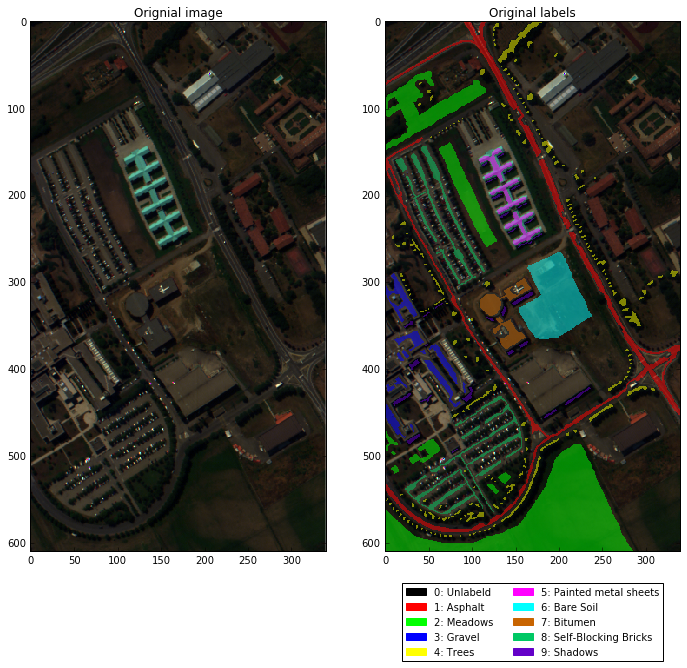

Label    Name                      Count     
0        Unlabeld                  164624    
1        Asphalt                   6631      
2        Meadows                   18649     
3        Gravel                    2099      
4        Trees                     3064      
5        Painted metal sheets      1345      
6        Bare Soil                 5029      
7        Bitumen                   1330      
8        Self-Blocking Bricks      3682      
9        Shadows                   947       


In [1]:
%run './../interface/hyperspectral_image.ipynb'

# Defining the model

Note that here Y and Yhat are OneHot encoded!

In [2]:
%run './../interface/tensorflow_defaults.ipynb'

In [3]:
%run './../interface/tensorflow_functions.ipynb'

In [4]:
XTrain = tf.constant(value=hyimage.splitPixels(stratified=True, trainProportion=0.2).XTrain, dtype=tf.float64, name='XTrain')
YTrain = tf.constant(value=hyimage.labelBinEncode(hyimage.splitPixels(stratified=True, trainProportion=0.2).YTrain), dtype=tf.int32, name='YTrain')

In [5]:
YTrain.eval()[0:5]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)

In [6]:
X = tf.placeholder_with_default(input=XTrain, shape=None, name='X')
Y = tf.placeholder_with_default(input=YTrain, shape=None, name='Y')

In [7]:
W = tf.Variable(tf.truncated_normal([hyimage.bandAmount, 10], seed=RANDOM_STATE, dtype=tf.float64), dtype=tf.float64, name='W')
b = tf.Variable(tf.truncated_normal([10], seed=RANDOM_STATE, dtype=tf.float64), dtype=tf.float64, name='b')

In [8]:
YhatSoftmax = tf.nn.softmax(tf.matmul(X, W) + b, name='YhatSoftmax')

In [9]:
Yhat = tf.one_hot(indices=tf.argmax(YhatSoftmax, dimension=1), depth=tf.shape(YTrain).eval()[1], dtype=tf.int32, name='Y')

In [10]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(tf.cast(Y, tf.float64) * tf.log(YhatSoftmax), reduction_indices=[1]))

In [11]:
tf.initialize_all_variables().run()

In [12]:
train_step = tf.train.GradientDescentOptimizer(2.5).minimize(cross_entropy)

In [13]:
train_step.run()
cross_entropy.eval()

3.2719137992858571

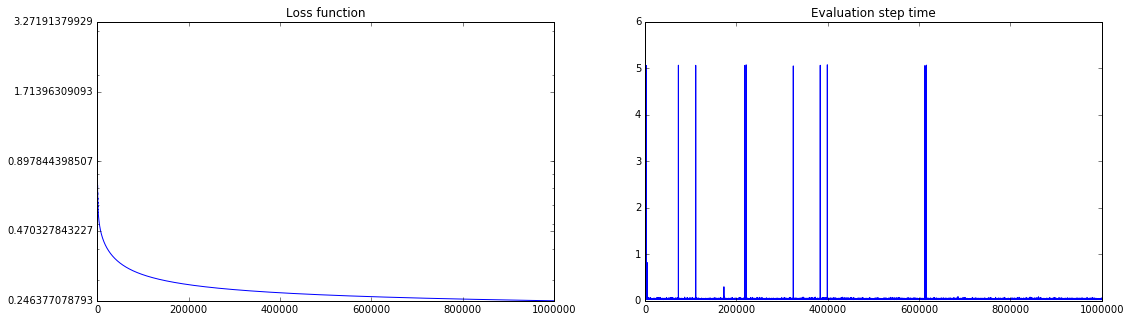

In [14]:
tfMinimize(_steps=1000000, _train_step=train_step, _loss=cross_entropy)

In [15]:
cross_entropy.eval()

0.24637706199234011

In [16]:
W.eval()[0:2]

array([[ -0.82170333,  -2.58926216,   5.94963001,  -0.74084981,
          4.11604201,   1.19676687,  -4.17809238, -12.12342479,
         -3.6197611 ,   5.43923456],
       [  0.36350097,  -6.41036246,  -4.71632609,  -2.00767512,
         -4.28530324,   2.26030088,  12.49324005,   0.63828308,
         -0.31284193,   2.97197037]])

In [17]:
Yhat.eval()[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [18]:
hyimage.labelBinDecode(Yhat.eval())

array([[2],
       [6],
       [3],
       ..., 
       [7],
       [2],
       [2]], dtype=uint8)

# Model evaluation

In [19]:
%run './../interface/model_evaluation_functions.ipynb'

In [20]:
tfAccuracyOneHotEncoded(YTensorOneHot=Y, YHatTensorOneHot=Yhat)

0.91315019

## Test data

In [25]:
feedTest = {X: hyimage.splitPixels(stratified=True, trainProportion=0.2).XTest, 
            Y: hyimage.labelBinEncode(hyimage.splitPixels(stratified=True, trainProportion=0.2).YTest)}

In [22]:
# same result as with tfAccuracyOneHotEncoded
# pyAccuracy(feedTest[Y], Yhat.eval(feed_dict=feedTest))

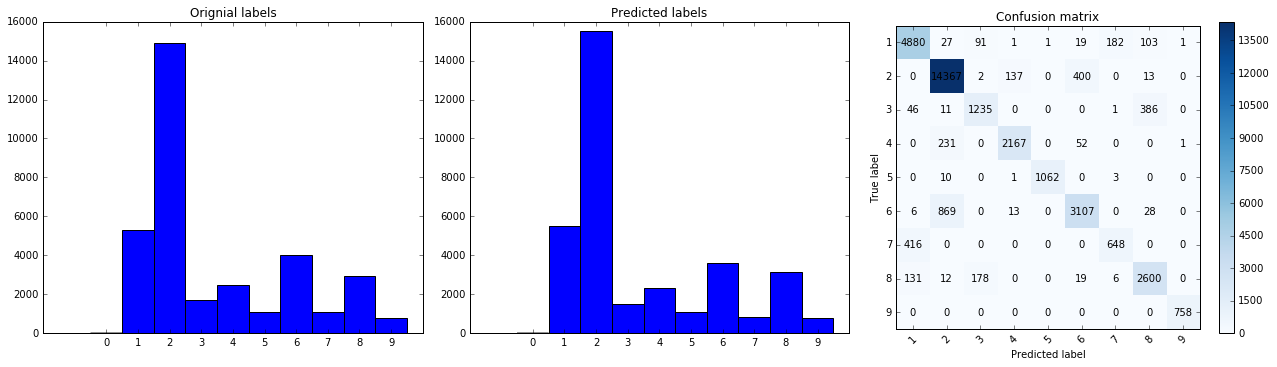

In [26]:
compareLabels(originalLabels=hyimage.splitPixels(stratified=True, trainProportion=0.2).YTest, 
              predictedLabels=hyimage.labelBinDecode(Yhat.eval(feed_dict=feedTest)))

In [27]:
tfAccuracyOneHotEncoded(YTensorOneHot=Y, YHatTensorOneHot=Yhat, feed=feedTest)

0.90073347

## Overall visualisation

In [28]:
feedAll = {X: hyimage.pixelsScaled, Y: hyimage.labelBinEncode(hyimage.pixelLabels)}

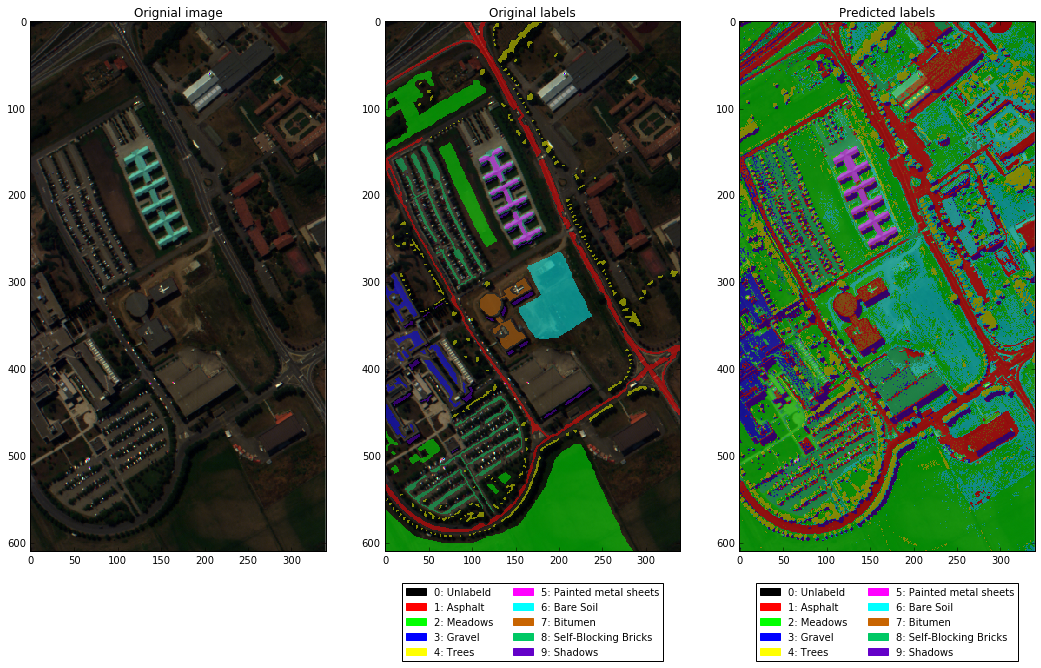

In [29]:
hyImageCompare(hyimage, hyimage.labelBinDecode(Yhat.eval(feed_dict=feedAll)).reshape(hyimage.labels.shape))

# Model comparison with predefined Logistic model

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
# regluarization parameter C=10e2 seems to be the best for the test data.
lReg = LogisticRegression(solver='newton-cg', max_iter=1000, C=10e2, n_jobs=-1)

In [32]:
lReg.fit(X=hyimage.splitPixels().XTrain, y=hyimage.splitPixels().YTrain.ravel())

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [33]:
pyAccuracy(Y=hyimage.splitPixels().YTrain, Yhat=lReg.predict(X=hyimage.splitPixels().XTrain))

0.87117138180967968

In [34]:
pyAccuracy(Y=hyimage.splitPixels().YTest, Yhat=lReg.predict(X=hyimage.splitPixels().XTest))

0.8530870931712512

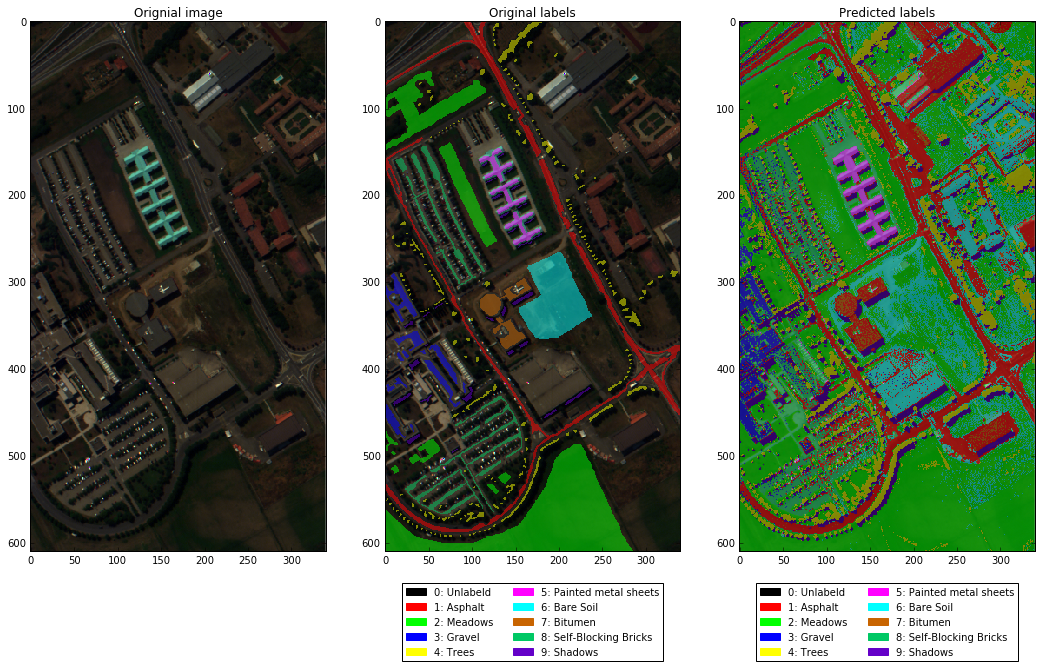

In [35]:
hyImageCompare(hyimage, lReg.predict(X=hyimage.pixelsScaled).reshape(hyimage.labels.shape))